In [1]:
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import heapq as hp
from queue import Queue
import tqdm

In [2]:
def create_erdos_graph(n, p):
    erdos_graph = nx.Graph()
    for i in range(n):
        erdos_graph.add_node(i)
    edges = itertools.combinations(range(n), 2)
    for e in edges:
        rand = random.uniform(0,1)
        if rand < p: 
            erdos_graph.add_edge(*e)
    return erdos_graph

def random_vertex(sets, r):    
    sets_options = [i for i in range(0, r-1) if sets[i]]
    i = random.choice(sets_options)
    v = random.choice(sets[i])
    sets[i].remove(v)
    return v

def random_min_degree_vertex(sets, graph, v1):
    done = False
    min_degree = 0
    while not done:
        if sets[min_degree]:
            options = [x for x in sets[min_degree] if x not in graph[v1]]
            if options:
                v2 = random.choice(options)
                done = True
            else:
                min_degree = min_degree+1
        else:
            min_degree = min_degree+1
    sets[min_degree].remove(v2)
    return v2
            

def create_random_graph(n, r):
    regular_graph = nx.Graph()
    if n*r % 2 != 0:
        print("n*r needs to be even!")
        return
    for i in range(n):
        regular_graph.add_node(i+1)
    graph = {i+1:[] for i in range(n)}
    sets = [[] for _ in range(r)]
    sets[0] = [i+1 for i in range(n)]
    while len(sets[r-1]) < n-1:
        v1 = random_vertex(sets, r)
        l = r - len(graph[v1])
        for i in range(l):
            v2 = random_min_degree_vertex(sets, graph, v1)
            graph[v1].append(v2)
            graph[v2].append(v1)
            v2_degree = len(graph[v2]) - 1
            sets[v2_degree].append(v2)
            regular_graph.add_edge(v1,v2)
        sets[r-1].append(v1)
    return regular_graph

# these two function check the "Direct" Connectivity between each pair of nodes using Networkx 'neighbors' function
def nodes_connected(G, u, v):
    return u in G.neighbors(v)

# Calculating Adjacency Matrix for given graph G
def create_adjacency_matrix(G, n, reg=True):
    _add = 1 if reg else 0
    return np.array([[1 if nodes_connected(G, i+_add, j+_add) \
                        else 0 for i in range(n)]  for j in range(n)], dtype="float")

# Calculating Laplacian Matrix of given graph G
def create_laplacian_matrix(G, n, reg=True):
    _add = 1 if reg else 0
    return np.array([[-1 if nodes_connected(G, i+_add, j+_add) \
                        else G.degree(j+_add) if i==j else 0 for i in range(n)]  for j in range(n)], dtype="float")

def bfs(G, root):
    node = {i: {"distance":float('Inf'), "parent":None} for i in G.nodes()}
    q = Queue()
    node[root]['distance'] = 0
    q.put(root)
    while not q.empty():
        current = q.get()
        for n in G.neighbors(current):
            if node[n]['distance'] == float('Inf'):
                node[n]['distance'] = node[current]['distance'] + 1
                node[n]['parent'] = current
                q.put(n)
    return node

def is_connected_bfs(G, root):
    res = bfs(G, root)
    for k, v in res.items():
        if k != root and v['parent'] is None:
            return 0
    return 1

def prob_erdos_graph(n, p, num_simulations=1000):
    return [(prob, sum([is_connected_bfs(create_erdos_graph(n, prob), 0) \
                          for _ in range(num_simulations)])/num_simulations) for prob in p]

def prob_regular_graph(n, r, num_simulations=1000):
    results = []
    for _r in r:
        connected = []
        working_simulations = 0
        for _ in range(num_simulations):
            try:
                connected.append(is_connected_bfs(create_random_graph(n, _r), 1))
                working_simulations += 1
            except:
                pass
        results.append((_r, sum(connected)/working_simulations))
    return results


def check_node(graph, node: int):
        '''
        Check if node exists on graph.
        Args:
            node: id of the node to be checked
        Return:
            True if node exists on graph, false otherwise
        '''
        try:
            graph.node[node]
            return True
        except KeyError:
            return False

def shortest_path(start: int, graph: nx.Graph, finish=None):
        '''
        Dijkstra algorithm for finding the shortest path.
        If finish is not set it finds the the shortest path between start and
        all the other nodes in graph.
        Args:
            start: The root node to find the shortest path from
            graph: The graph object to look for the shortest path
            finish (int): The destination node to find the shortest path
        Returns:
            A tuple where element 0 dict is the shortest path between start
            and all the other nodes, and element 1 is a dict with the node as
            a key and the value is the previous node on the path to that node.
            If finish is given the iteration stops when finds finish but it still
            returns the same tuple
        '''

        distances = {}
        prev = {}
        for node in graph.nodes():
            distances[node] = float('inf')
        distances[start] = 0
        if not check_node(graph, start) or finish is not None and not check_node(graph, finish):
            return distances, None
        p_queue = []
        hp.heappush(p_queue, (0, start))
        visited = set()
        while p_queue:
            dist, node = hp.heappop(p_queue)
            if finish is not None:
                if node == finish:
                    return distances, prev
            if node not in visited:
                visited.add(node)
                for edge in graph.edges(node, data=True):
                    neighbour = edge[1]
                    weigth = 1
                    _dist = dist + weigth
                    if _dist < distances[neighbour]:
                        distances[neighbour] = _dist
                        prev[neighbour] = node
                    if neighbour not in visited:
                        hp.heappush(p_queue, (_dist, neighbour))
        return distances, prev

def generate_path(source, prev):
    res = {source:{k:[] for k in prev}}
    for key in prev:
        prev_key = prev[key]
        while prev_key != source:
            res[source][key].append(prev_key)
            prev_key = prev[prev_key]
        res[source][key].append(source)
    return res

def shortest_routes_hbar(graph):
    shortest_paths = {}
    avgs_distances = 0
    for node in graph.nodes():
        dist, prev = shortest_path(graph=graph, start=node)
        avgs_distances += sum(dist.values())/len(dist)
        shortest_paths[node] = generate_path(node, prev)[node]
    h_bar = avgs_distances/(len(graph.nodes())-1)
    return shortest_paths, h_bar

def th_n(n, num_simulations=10, erdos=True):
    result = []
    for i in tqdm.tqdm(n):
        number_of_edges = 0
        h_bar_sum = 0
        for _ in range(num_simulations):
            if erdos:
                p = 8/(i-1)
                graph = create_erdos_graph(i, p)
            else:
                r = 8
                graph = create_random_graph(i, r)
            _, h_bar = shortest_routes_hbar(graph)
            number_of_edges += graph.number_of_edges()
            h_bar_sum += h_bar
        avg_num_edges = number_of_edges/num_simulations
        avg_h_bar = h_bar_sum/num_simulations
        th_bound = avg_num_edges/(avg_h_bar*(i*(i-1)/2))
        result.append((i, th_bound))
    return result

def th_q(q, num_simulations=10, erdos=True):
    result = []
    for i in tqdm.tqdm(q):
        number_of_edges = 0
        h_bar_sum = 0
        for _ in range(num_simulations):
            if erdos:
                p = 8/99
                graph = create_erdos_graph(100, p)
            else:
                r = 8
                graph = create_random_graph(100, r)
            
            ## Test if link breaks
            for edge in graph.edges():
                randn = random.uniform(0, 1)
                if randn <= i:
                    graph.remove_edge(edge[0], edge[1])
    
            _, h_bar = shortest_routes_hbar(graph)
            number_of_edges += graph.number_of_edges()
            h_bar_sum += h_bar
        
        avg_num_edges = number_of_edges/num_simulations
        avg_h_bar = h_bar_sum/num_simulations
        th_bound = avg_num_edges/(avg_h_bar*(100*(100-1)/2))
        result.append((i, th_bound))
    return result

In [3]:
n = int(input('Enter Number of Nodes: '))
p = float(input('Enter P value: '))
r = int(input('Enter r to create r-Regular Graph: '))

Enter Number of Nodes: 10
Enter P value: 0.2
Enter r to create r-Regular Graph: 8


In [4]:
erdos_graph = create_erdos_graph(n, p)
regular_graph = create_random_graph(n, r)

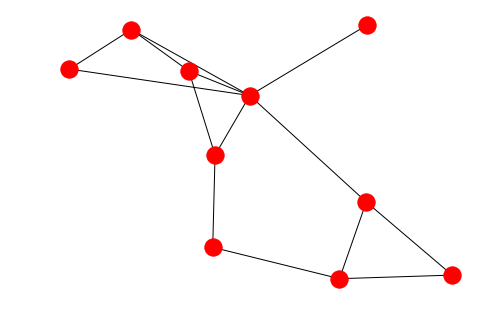

In [6]:
import warnings
nx.draw(erdos_graph)
plt.show()
warnings.filterwarnings('ignore')

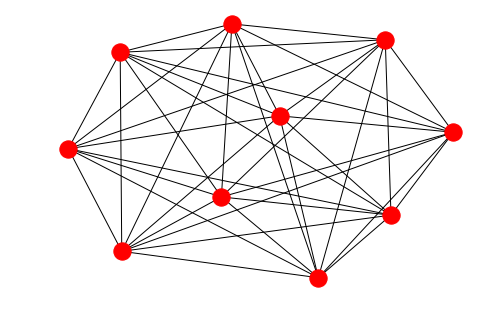

In [7]:
nx.draw(regular_graph)
plt.show()

# Check Connectivity of matrix using Irreducibility

In [8]:
erdos_matrix = create_adjacency_matrix(erdos_graph, n, False)
regular_matrix = create_adjacency_matrix(regular_graph, n, True)

In [9]:
# Caclulating Irreducibility of Adjacency Matrix, (If I + A + A^2 + ... + A^n-1 > 0 then A is Irreducibile which
# means our Graph is connected)
res_erdos_matrix = erdos_matrix.copy()
res_regular_matrix = regular_matrix.copy()
for i in range(n-1):
    res_erdos_matrix += np.matmul(res_erdos_matrix, erdos_matrix)
    res_regular_matrix += np.matmul(res_regular_matrix, regular_matrix)
    
print(res_erdos_matrix)
print(res_regular_matrix)

[[ 37166.  51031.   9562.  24106.  24754.      0.  11427.  16827.   4415.
   41989.]
 [ 51031.  70453.  13372.  33456.  34628.      0.  16403.  22934.   6531.
   57562.]
 [  9562.  13372.   2807.   6629.   6531.      0.   3031.   4203.   1172.
   10734.]
 [ 24106.  33456.   6629.  16179.  16403.      0.   7703.  10734.   3031.
   27137.]
 [ 24754.  34628.   6531.  16403.  17869.      0.   9263.  10946.   4061.
   27830.]
 [     0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.]
 [ 11427.  16403.   3031.   7703.   9263.      0.   5527.   4896.   2732.
   12766.]
 [ 16827.  22934.   4203.  10734.  10946.      0.   4896.   7701.   1820.
   19055.]
 [  4415.   6531.   1172.   3031.   4061.      0.   2732.   1820.   1466.
    4896.]
 [ 41989.  57562.  10734.  27137.  27830.      0.  12766.  19055.   4896.
   47462.]]
[[  3.09936392e+08   3.09936392e+08   3.09936391e+08   3.09936391e+08
    3.09936391e+08   3.09936391e+08   3.09936391e+08   3.09936391e+08
    3.099

In [13]:
print(np.all(res_erdos_matrix > 0))
print(np.all(res_regular_matrix > 0))

True
False


# Check the connectivity of matrix using eigenvalue of the Laplacian matrix

In [14]:
erdos_laplacian = create_laplacian_matrix(erdos_graph, n, False)
regular_laplacian = create_laplacian_matrix(regular_graph, n, True)

In [15]:
# Calculating Eigenvals Vector of Laplacian matrix of represented Erdos Renyi Graph
erdos_eigen = np.linalg.eigvals(erdos_laplacian)
regular_eigen = np.linalg.eigvals(regular_laplacian)

In [16]:
# Since, the Second smallest eigenvalue in this vector is positive, our graph is connected
regular_eigen.sort()
erdos_eigen.sort()
print(regular_eigen[1] > 0)
print(erdos_eigen[1] > 0)

False
True


In [17]:
erdos_bfs = bfs(erdos_graph, 0)
regular_bfs = bfs(regular_graph, 1)

In [18]:
regular_bfs

{1: {'distance': 0, 'parent': None},
 2: {'distance': 22, 'parent': 22},
 3: {'distance': inf, 'parent': None},
 4: {'distance': 21, 'parent': 7},
 5: {'distance': 32, 'parent': 51},
 6: {'distance': inf, 'parent': None},
 7: {'distance': 20, 'parent': 91},
 8: {'distance': 25, 'parent': 87},
 9: {'distance': 16, 'parent': 39},
 10: {'distance': 4, 'parent': 83},
 11: {'distance': 3, 'parent': 23},
 12: {'distance': 27, 'parent': 94},
 13: {'distance': inf, 'parent': None},
 14: {'distance': 19, 'parent': 38},
 15: {'distance': inf, 'parent': None},
 16: {'distance': 6, 'parent': 77},
 17: {'distance': 39, 'parent': 93},
 18: {'distance': inf, 'parent': None},
 19: {'distance': 9, 'parent': 71},
 20: {'distance': 1, 'parent': 1},
 21: {'distance': inf, 'parent': None},
 22: {'distance': 21, 'parent': 26},
 23: {'distance': 2, 'parent': 20},
 24: {'distance': 33, 'parent': 5},
 25: {'distance': 2, 'parent': 50},
 26: {'distance': 20, 'parent': 14},
 27: {'distance': 16, 'parent': 75},
 

In [19]:
erdos_bfs

{0: {'distance': 0, 'parent': None},
 1: {'distance': 2, 'parent': 6},
 2: {'distance': 2, 'parent': 6},
 3: {'distance': 2, 'parent': 14},
 4: {'distance': 2, 'parent': 22},
 5: {'distance': 2, 'parent': 6},
 6: {'distance': 1, 'parent': 0},
 7: {'distance': 2, 'parent': 22},
 8: {'distance': 2, 'parent': 10},
 9: {'distance': 2, 'parent': 10},
 10: {'distance': 1, 'parent': 0},
 11: {'distance': 2, 'parent': 12},
 12: {'distance': 1, 'parent': 0},
 13: {'distance': 2, 'parent': 6},
 14: {'distance': 1, 'parent': 0},
 15: {'distance': 1, 'parent': 0},
 16: {'distance': 2, 'parent': 10},
 17: {'distance': 2, 'parent': 10},
 18: {'distance': 1, 'parent': 0},
 19: {'distance': 2, 'parent': 18},
 20: {'distance': 2, 'parent': 15},
 21: {'distance': 2, 'parent': 18},
 22: {'distance': 1, 'parent': 0},
 23: {'distance': 2, 'parent': 14},
 24: {'distance': 2, 'parent': 14},
 25: {'distance': 2, 'parent': 14},
 26: {'distance': 1, 'parent': 0},
 27: {'distance': 2, 'parent': 26},
 28: {'dista

Irreducibility and Eigenvalue of the Laplacian matrix is O($n^2$) and BFS for the regular graph, the complexity is $O(n + \frac{n*r}{2} = O(n*r))$ where $\frac{n*r}{2}$ is the number of Edges, for the regular graph the complexity is $O(n+\frac{n(n-1)}{2}*p) = O(n^2*p)$

In [20]:
p_space = np.append(np.linspace(0, 0.05, 20), np.linspace(0.1, 1, 10))
erdos_probs = prob_erdos_graph(100, p_space)

In [21]:
random_probs = prob_regular_graph(100, [2,4,8,16])

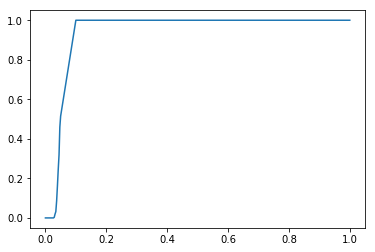

In [22]:
plt.plot(*zip(*erdos_probs))

plt.show()

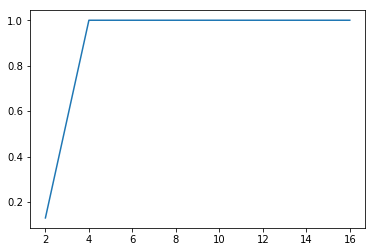

In [23]:
plt.plot(*zip(*random_probs))
plt.show()

## Part 2

### 2.1 Throughput performance

In [24]:
# generating random graphs describing the topology of the ToR switch network
tor_erdos = create_erdos_graph(100, 8/99)
tor_regular = create_random_graph(100, 8)

## Check connectivity

In [25]:
is_connected_bfs(tor_erdos, 0)

1

In [26]:
is_connected_bfs(tor_regular, 1)

1

## Find shortest path routes and estimate h-bar

In [27]:
shortest_paths_erdos, h_bar_erdos = shortest_routes_hbar(tor_erdos)
shortest_paths_regular, h_bar_regular = shortest_routes_hbar(tor_regular)

## TH bound

The application-oblivious throughput bounds states that $TH \le \frac{m}{(\bar{h}ν_f)}$, where *m* is the number of links of the network graph, $\bar{h}$ is the mean path length and $ν_f$ is the number of flows.<br />
Assuming an all-to-all traffic matrix: then $ν_f = \frac{n(n − 1)}{2}$ <br />
In case of *r-regular* random graph, the number of links is $m = \frac{nr}{2}$ and In case of *p-ER* graph, the number of links is an outcome of the random generation, hence it is a random variable with mean $m = \frac{pn(n − 1)}{2}$

In [29]:
erdos_th_bound = th_n(range(9,100), erdos=True)
regular_th_bound = th_n(range(9,100), erdos=False)

100%|██████████| 91/91 [00:38<00:00,  1.14s/it]


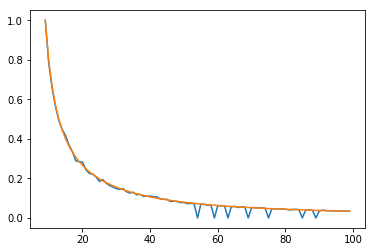

In [30]:
plt.plot(*zip(*erdos_th_bound))
plt.plot(*zip(*regular_th_bound))

plt.show()

## 2.2 Reliablity Performance

In [33]:
erdos_th_qbound = th_q(np.linspace(0, 0.25, 22), erdos=True)
regular_th_qbound = th_q(np.linspace(0, 0.25, 22), erdos=False)

100%|██████████| 22/22 [00:23<00:00,  1.04s/it]


Assuming a link can break down (fail) with probability *q* then diagram below illustrates *TH* as a function of *q* for $0 < q \le 0.25$, (for the two network models in point 1) above with $n = 100$.

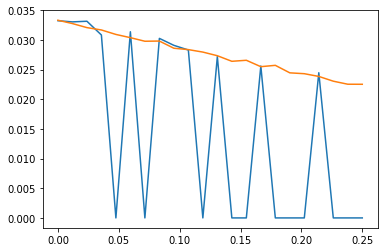

In [34]:
plt.plot(*zip(*erdos_th_qbound))
plt.plot(*zip(*regular_th_qbound))

plt.show()